In [1]:
import platform
print(f"platform.python_version(): {platform.python_version()}")

import os
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

# 檢查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

platform.python_version(): 3.9.18
Using device: cuda


In [13]:
#######################################################################
#載入mfcc為data
npy_file_list = glob(f"..\\data\\mfcc\\*.npy")
print(f"type(npy_file_list): {type(npy_file_list)}")
print(f"len(npy_file_list): {len(npy_file_list)}")

mfcc_list = []

for npy_file in tqdm(npy_file_list):
    mfcc = np.load(file=npy_file)
    mfcc_list.append(mfcc)

mfcc_list = np.array(mfcc_list)
print(f"type(mfcc_list): {type(mfcc_list)}")
print(f"mfcc_list.shape: {mfcc_list.shape}")

all_mfcc = []
for mfcc in mfcc_list:
    all_mfcc.append(mfcc)

data = np.array(all_mfcc)
data_len = len(data)
#######################################################################

#######################################################################
#載入labelByself為labels
load_data = np.load(f"..\\labelByself.npz")
labels = load_data['data']
#######################################################################

every_epoch = [] 
every_d_loss = []
every_g_loss = []
every_DZ = []

class PhonemeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class ConditionalGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_shape, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.output_shape = output_shape
        self.output_dim = output_shape[0] * output_shape[1]
        self.label_embedding = nn.Embedding(num_classes, input_dim)  # 將類別標籤轉換為與 z 相同維度的向量
        self.model = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 4), 
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, self.output_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_embedding(labels)
        input_data = torch.cat([z, label_embedding], dim=1)  # 將噪聲 z 與條件 labels 拼接
        x = self.model(input_data)
        return x.view(x.size(0), *self.output_shape)


class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_shape, hidden_dim, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.input_dim = input_shape[0] * input_shape[1]
        self.label_embedding = nn.Embedding(num_classes, self.input_dim)  # 將類別標籤轉換為與輸入數據相同維度的向量
        self.model = nn.Sequential(
            nn.Linear(self.input_dim * 2, hidden_dim * 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels)
        input_data = torch.cat([x.view(x.size(0), -1), label_embedding], dim=1)  # 將輸入數據與條件 labels 拼接
        return self.model(input_data)


# 假設原始MFCC矩陣的形狀為(13, 44)
mfcc_shape = (13, 44)
input_dim =  2048 # 生成器的輸入維度2048
hidden_dim = 128
num_classes = 1467

# 初始化生成器和判別器
generator = ConditionalGenerator(input_dim, hidden_dim, mfcc_shape, num_classes).to(device)
discriminator = ConditionalDiscriminator(mfcc_shape, hidden_dim,num_classes).to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.00000001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00000001)#0.0000001

# 創建數據集和數據加載器
dataset = PhonemeDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 訓練GAN模型
num_epochs = 1000
d_steps = 1  # 每個生成器步驟後訓練判別器的步數
g_steps = 3  # 每個判別器步驟後訓練生成器的步數

for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(dataloader):
        data = data.to(device)
        labels = labels.to(device)  # 標籤同樣移動到設備上
        batch_size = data.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 訓練判別器
        for _ in range(d_steps):
            outputs = discriminator(data, labels)  # 輸入數據和對應的標籤
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            z = torch.randn(batch_size, input_dim).to(device)
            fake_data = generator(z, labels)  # 使用相同的標籤生成數據
            outputs = discriminator(fake_data.detach(), labels)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = d_loss_real + d_loss_fake
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # 訓練生成器
        for _ in range(g_steps):
            z = torch.randn(batch_size, input_dim).to(device)
            fake_data = generator(z, labels)  # 使用相同的標籤生成數據
            outputs = discriminator(fake_data, labels)
            g_loss = criterion(outputs, real_labels)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    
    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
          f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    every_epoch.append(epoch)
    every_d_loss.append(d_loss.item())
    every_g_loss.append(g_loss.item())
    every_DZ.append(fake_score.mean().item())


print('訓練完成！')

type(npy_file_list): <class 'list'>
len(npy_file_list): 35287


100%|██████████| 35287/35287 [00:06<00:00, 5791.66it/s]


type(mfcc_list): <class 'numpy.ndarray'>
mfcc_list.shape: (35287, 13, 44)
Epoch [1/1000], d_loss: 1.5395, g_loss: 0.7295, D(x): 0.43, D(G(z)): 0.48
Epoch [2/1000], d_loss: 1.4687, g_loss: 0.7325, D(x): 0.49, D(G(z)): 0.48
Epoch [3/1000], d_loss: 1.6055, g_loss: 0.7285, D(x): 0.43, D(G(z)): 0.48
Epoch [4/1000], d_loss: 1.5147, g_loss: 0.7355, D(x): 0.45, D(G(z)): 0.48
Epoch [5/1000], d_loss: 1.5468, g_loss: 0.7272, D(x): 0.45, D(G(z)): 0.48
Epoch [6/1000], d_loss: 1.4578, g_loss: 0.7344, D(x): 0.46, D(G(z)): 0.48
Epoch [7/1000], d_loss: 1.6102, g_loss: 0.7329, D(x): 0.42, D(G(z)): 0.48
Epoch [8/1000], d_loss: 1.4405, g_loss: 0.7328, D(x): 0.47, D(G(z)): 0.48
Epoch [9/1000], d_loss: 1.4525, g_loss: 0.7322, D(x): 0.46, D(G(z)): 0.48
Epoch [10/1000], d_loss: 1.4348, g_loss: 0.7296, D(x): 0.47, D(G(z)): 0.48
Epoch [11/1000], d_loss: 1.3862, g_loss: 0.7252, D(x): 0.50, D(G(z)): 0.48
Epoch [12/1000], d_loss: 1.3547, g_loss: 0.7253, D(x): 0.52, D(G(z)): 0.48
Epoch [13/1000], d_loss: 1.4505, g_

In [ ]:
torch.save(generator.state_dict(), 'cGAN_generator_model.pth')

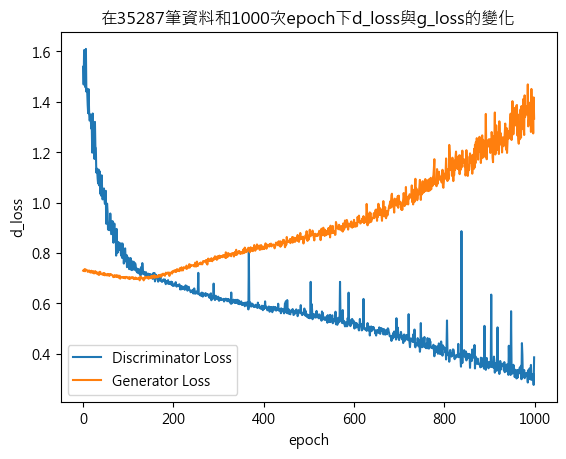

In [14]:
plt.plot(every_epoch,  every_d_loss, linestyle='-', label='Discriminator Loss')
plt.plot(every_epoch,  every_g_loss, linestyle='-', label='Generator Loss')
plt.title(f'在{data_len}筆資料和{num_epochs}次epoch下d_loss與g_loss的變化')
plt.xlabel('epoch')
plt.ylabel('d_loss')


plt.legend() 

plt.show()

In [6]:
labels = torch.tensor([0] * batch_size).to(device)  # 生成標籤為 10 的資料
fake_data = generator(z, labels)

In [7]:
fake_data[0]

tensor([[-1.3963e-01, -5.7526e-02, -2.8917e-01, -3.1526e-01, -1.8496e-01,
         -3.4675e-01, -1.9888e-01,  2.3545e-01,  3.9849e-03,  1.2673e-01,
         -1.5811e-01, -4.6341e-01, -2.8550e-01,  1.4929e-01,  3.3220e-01,
          1.0852e-01,  5.6662e-01, -2.0889e-03,  1.8429e-01, -2.9890e-01,
          1.3085e-01,  4.1196e-01,  1.4706e-01, -2.5638e-01,  1.0131e-01,
         -2.5130e-01, -8.4573e-02, -1.6859e-01, -3.0813e-02, -1.7142e-01,
         -2.0911e-01, -4.6694e-01, -2.0568e-01, -2.7094e-01,  4.1624e-01,
         -1.7050e-01, -1.4946e-01, -4.4927e-01,  3.7958e-03,  4.7488e-01,
          1.0045e-01,  1.7025e-02,  8.6403e-02, -2.4957e-01],
        [ 7.0983e-01, -2.9282e-01, -1.7517e-02,  1.3027e-01, -3.8194e-01,
          1.6583e-01,  5.0898e-01, -4.6685e-01, -1.7820e-01,  3.2912e-01,
         -1.9394e-01, -1.2638e-01,  3.1791e-01,  2.7253e-01,  4.4557e-02,
          1.0657e-01, -2.3042e-01,  4.0665e-01,  9.8876e-02, -9.9301e-02,
         -1.3348e-01,  3.7261e-01, -1.0361e-01,  5